In [2]:
from PIL import Image
import os

root_folder = 'data'
new_root_folder = 'reshaped_data'


class_folders = ['COVID', 'NORMAL', 'PNEUMONIA']


new_size = (128, 128)

def reshape_images(class_folder):
    folder_path = os.path.join(root_folder, class_folder)
    new_folder_path = os.path.join(new_root_folder, f'{class_folder}')

    os.makedirs(new_folder_path, exist_ok=True)


    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)


            img = Image.open(image_path)


            img_resized = img.resize(new_size)
            img_rgb = img_resized.convert('RGB')


            new_image_path = os.path.join(new_folder_path, filename)
            img_rgb.save(new_image_path)


for class_folder in class_folders:
    reshape_images(class_folder)


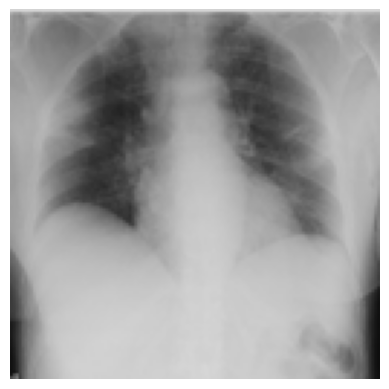

In [3]:
import matplotlib.pyplot as plt

image_path = 'reshaped_data/COVID/COVID_10.png'
img = Image.open(image_path)


plt.imshow(img)
plt.axis('off')
plt.show()


In [4]:
import os
from sklearn.model_selection import train_test_split
import shutil


root_folder = 'reshaped_data'


class_folders = ['COVID', 'NORMAL', 'PNEUMONIA']


train_folder = 'train_data'
test_folder = 'test_data'
val_folder = 'val_data'


os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)


for class_folder in class_folders:
    class_path = os.path.join(root_folder, class_folder)


    image_filenames = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]


    train_val_filenames, test_filenames = train_test_split(image_filenames, test_size=0.2, random_state=42)
    train_filenames, val_filenames = train_test_split(train_val_filenames, test_size=0.1, random_state=42)


    train_class_folder = os.path.join(train_folder, class_folder)
    test_class_folder = os.path.join(test_folder, class_folder)
    val_class_folder = os.path.join(val_folder, class_folder)

    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)
    os.makedirs(val_class_folder, exist_ok=True)


    for filename in train_filenames:
        src_path = os.path.join(class_path, filename)
        dest_path = os.path.join(train_class_folder, filename)
        shutil.move(src_path, dest_path)

    for filename in test_filenames:
        src_path = os.path.join(class_path, filename)
        dest_path = os.path.join(test_class_folder, filename)
        shutil.move(src_path, dest_path)

    for filename in val_filenames:
        src_path = os.path.join(class_path, filename)
        dest_path = os.path.join(val_class_folder, filename)
        shutil.move(src_path, dest_path)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)


batch_size = 25


train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    val_folder,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 3762 images belonging to 3 classes.
Found 1047 images belonging to 3 classes.
Found 419 images belonging to 3 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Creating a model
model = Sequential()

# Convolutional Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# Adding additional convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening Layer
model.add(Flatten())

# Dense Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# Adding additional Dense layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
num_classes = 3 # num_classes is the number of classes in your classification task
model.add(Dense(num_classes, activation='softmax'))

e:\Machine Learning\Detection_COVID\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [8]:
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras.optimizers import Adam


# Define the number of epochs
# epochs = 100
# epochs = 200
# Trained for 150 epochs
epochs = 150

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

optimizer = Adam(learning_rate=1e-3, beta_1=0.8)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    batch_size=batch_size,
    callbacks=[early_stopping]
)


Epoch 1/150


e:\Machine Learning\Detection_COVID\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - accuracy: 0.3792 - loss: 1.0453 - val_accuracy: 0.8258 - val_loss: 0.6180
Epoch 2/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.7138 - loss: 0.6365 - val_accuracy: 0.8401 - val_loss: 0.4310
Epoch 3/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.8524 - loss: 0.4003 - val_accuracy: 0.9212 - val_loss: 0.2522
Epoch 4/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.9017 - loss: 0.3138 - val_accuracy: 0.8974 - val_loss: 0.3265
Epoch 5/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.9281 - loss: 0.2465 - val_accuracy: 0.9379 - val_loss: 0.1631
Epoch 6/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.9338 - loss: 0.2108 - val_accuracy: 0.9308 - val_loss: 0.1917
Epoch 7/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.9487 - loss: 0.1748 - val_accuracy: 0.9642 - val_loss: 0.1298
Epoch 8/150
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.9620 - loss: 0.150

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9539 - loss: 0.1942
Test Loss: 0.1887899786233902, Test Accuracy: 0.9512894153594971


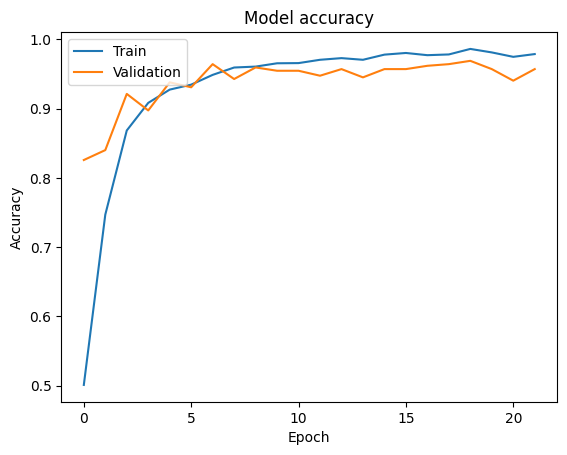

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.show()


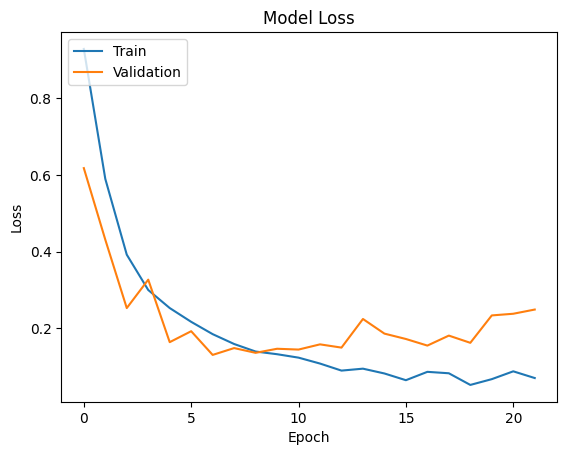

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [22]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the saved model
# Define class labels
class_labels = ["COVID", "NORMAL", "PNEUMONIA"]

# Load and preprocess the input image
img_path = 'test_data\COVID\COVID_17.png'
img = image.load_img(img_path, target_size=(128, 128))  # Load image and resize
img_array = image.img_to_array(img)  # Convert image to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values

# Make predictions
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: COVID


In [14]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
from sklearn.metrics import accuracy_score


root_directory = 'test_data'

class_names = ['COVID', 'NORMAL', 'PNEUMONIA']

true_labels = []
predicted_labels = []


for class_name in class_names:
    class_directory = os.path.join(root_directory, class_name)


    for file_name in os.listdir(class_directory):

        file_path = os.path.join(class_directory, file_name)

        img = load_img(file_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        true_label = class_names.index(class_name)
        true_labels.append(true_label)


        predictions = model.predict(img_array)
        predicted_label = np.argmax(predictions[0])
        predicted_labels.append(predicted_label)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

Precision: 0.8486
Recall: 0.7689
F1 Score: 0.7611
Confusion Matrix:


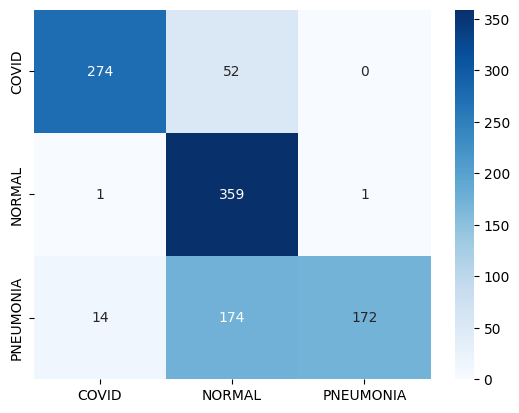

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels,predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())


print('Confusion Matrix:')

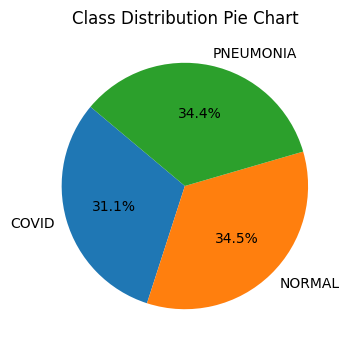

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class_names = ['COVID', 'NORMAL', 'PNEUMONIA']


class_counts = Counter(true_labels)


plt.figure(figsize=(4,4))
plt.pie(class_counts.values(), labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution Pie Chart')
plt.show()


In [19]:
import pickle
with open('model.pkl','wb') as files:
    pickle.dump(model,files)

In [23]:
model.save('model_detect.h5')